In [1]:
import urllib.request
import json
import sys
import codecs
import io
import pandas as pd
import numpy as np
import networkx as nx
from scipy.linalg import eigh, inv
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
#Upload the file
uploader = widgets.FileUpload(multiple=False)
display(uploader)

FileUpload(value={}, description='Upload')

In [3]:
uploaded_file = list(uploader.value.values())[0]

In [4]:
#Convert uploaded file to pandas data frame
dfTCPA = pd.read_csv(io.BytesIO(uploaded_file["content"]))

In [5]:
#Get gene names to be used in graph later
geneList = dfTCPA.columns[4:dfTCPA.index.stop]

#Define the cutoff for significant gene/protein expression
SIGEXPR = 0.45

#Create final dataframe to hold significant gene/protein expression
corrJak2Df = pd.DataFrame()
corrStat3Df = pd.DataFrame()

In [6]:
#Calculate correlation for each column in TCPA with respect to JAK2
#Will turn this into a function later
for col in geneList: 
    corrCoeff = dfTCPA["JAK2"].corr(dfTCPA[col])
    if(abs(corrCoeff) > SIGEXPR and col != "JAK2"):
        dfHolder = pd.DataFrame({col: corrCoeff}, index=[0])
        corrJak2Df = pd.concat([dfHolder, corrJak2Df], axis=1)

        
#Calculate correlation for each column in TCPA with respect to STAT3
for col in geneList: 
    corrCoeff = dfTCPA["STAT3_pY705"].corr(dfTCPA[col])
    if(abs(corrCoeff) > SIGEXPR and col != "STAT3_pY705"):
        dfHolder = pd.DataFrame({col: corrCoeff}, index=[0])
        corrStat3Df = pd.concat([dfHolder, corrStat3Df], axis=1)
        
#Add the gene the analysis was done with respect to (i.e. JAK2 or STAT3)
corrJak2Df['JAK2'] = 'NaN'
corrStat3Df['STAT3'] = 'NaN'

In [7]:
#Output final result so far
corrJak2Df

,NRF2,LCN2A,PI3KP85,TUBERIN,STATHMIN,STAT5ALPHA,MTOR,MRE11,ATM,JAK2
0,-0.46625,-0.464228,0.458117,0.505792,-0.49182,0.665408,0.468928,-0.456898,0.523329,NaN


In [8]:
corrStat3Df

,THYMIDILATESYNTHASE,SHP2_pY542,GSK3_pS9,MTOR_pS2448,GSK3ALPHABETA_pS21S9,CAVEOLIN1,AKT_pS473,X4EBP1,STAT3
0,-0.455796,0.45508,0.487995,0.488616,0.466608,0.456366,0.526362,-0.490331,NaN


In [9]:
corrStat3Df["SHP2_pY542"]

0    0.45508
Name: SHP2_pY542, dtype: float64

In [10]:
corrStat3Df.columns

Index(['THYMIDILATESYNTHASE', 'SHP2_pY542', 'GSK3_pS9', 'MTOR_pS2448',
       'GSK3ALPHABETA_pS21S9', 'CAVEOLIN1', 'AKT_pS473', 'X4EBP1', 'STAT3'],
      dtype='object')

In [11]:
corrStat3Df.columns.tolist()

['THYMIDILATESYNTHASE',
 'SHP2_pY542',
 'GSK3_pS9',
 'MTOR_pS2448',
 'GSK3ALPHABETA_pS21S9',
 'CAVEOLIN1',
 'AKT_pS473',
 'X4EBP1',
 'STAT3']

In [12]:
#Taken and modified from https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-021-04148-x
class HypothesisNetwork(object):
    
    def __init__(self, endpoint):
        endpoint = endpoint.replace(' ', '_').replace('/', '_').lower()
        url = urllib.request.urlopen(BASE_URL + 'json/%s.json' % endpoint)
        data = json.loads(url.read())
        self.endpoint = data['graph']['endpoint']
        self.category = data['graph']['category']
        self._nodes = data['graph']['nodes']
        self._edges = data['graph']['edges']
        self._node_id_map = {n['label']:n['id'] for n in self._nodes}
        self._id_node_map = {n['id']:n['label'] for n in self._nodes}
        self.nodes = list(self._node_id_map)
        self.edges = [(self._id_node_map[e['from']], self._id_node_map[e['to']]) for e in self._edges]
  

# __repr__ turns object into a string
#    def __repr__(self):
#        return self.endpoint
    
# methods    def get_drugs(self, node): 
#            def get_node_description(self, node):


In [13]:
#My own class to draw graph
class KnowledgeTree(object):
    
    def __init__(self, dataFrame):
        #Private variables
        #self._nodes = dataFrame.columns.tolist()
        #self._edges
        
        #Public Variables
        self.nodes = dataFrame.columns.map(str)
        self.edges = "TCPA"
        


In [14]:
jak2graph = KnowledgeTree(corrJak2Df)
stat3graph = KnowledgeTree(corrStat3Df)

In [15]:
stat3graph.nodes

Index(['THYMIDILATESYNTHASE', 'SHP2_pY542', 'GSK3_pS9', 'MTOR_pS2448',
       'GSK3ALPHABETA_pS21S9', 'CAVEOLIN1', 'AKT_pS473', 'X4EBP1', 'STAT3'],
      dtype='object')

In [16]:
jak2graph.nodes

Index(['NRF2', 'LCN2A', 'PI3KP85', 'TUBERIN', 'STATHMIN', 'STAT5ALPHA', 'MTOR',
       'MRE11', 'ATM', 'JAK2'],
      dtype='object')

In [15]:
#Creating the knowledge graph
KG = nx.Graph()

#Add the nodes
for i in range(len(jak2graph.nodes)):
    KG.add_node(jak2graph.nodes[i])
    
for i in range(len(stat3graph.nodes)):
    KG.add_node(stat3graph.nodes[i])

#Each edge form is a tuple (node1, node2, {'weight': weight})
for i in range(len(jak2graph.nodes)-1):
    KG.add_edge(jak2graph.nodes[i], jak2graph.nodes[len(jak2graph.nodes)-1], dataFrom=jak2graph.edges)
    
for i in range(len(stat3graph.nodes)-1):
    KG.add_edge(stat3graph.nodes[i], stat3graph.nodes[len(stat3graph.nodes)-1], dataFrom=stat3graph.edges)

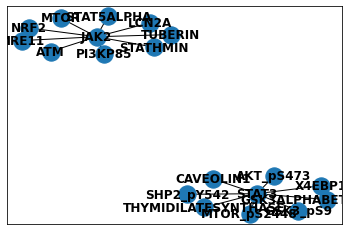

In [16]:
nx.draw_networkx(KG, with_labels=True, font_weight='bold')

In [17]:
%matplotlib widget

In [ ]:
with plt.ion():
    rcParams.update({'figure.autolayout': True})
    fig, ax = plt.subplots(figsize=(12, 12))
    pos=nx.spring_layout(KG, seed=63)
    nx.draw_networkx(KG, with_labels=True)
    
    ax.margins(0.01, 0.05)
    fig.tight_layout()
    plt.axis("off")
    plt.show()

In [18]:
corrJak2Df['STAT3'] = .17706
corrStat3Df['JAK2'] = .17706
jak2graph = KnowledgeTree(corrJak2Df)
stat3graph = KnowledgeTree(corrStat3Df)

In [19]:
jak2graph.nodes

Index(['NRF2', 'LCN2A', 'PI3KP85', 'TUBERIN', 'STATHMIN', 'STAT5ALPHA', 'MTOR',
       'MRE11', 'ATM', 'JAK2', 'STAT3'],
      dtype='object')

In [20]:
#Creating the knowledge graph
KG = nx.Graph()

#Add the nodes

for i in range(len(jak2graph.nodes)):
    KG.add_node(jak2graph.nodes[i])
    
for i in range(len(stat3graph.nodes)):
    KG.add_node(stat3graph.nodes[i])

#Each edge form is a tuple (node1, node2, {'weight': weight})
for i in range(len(jak2graph.nodes)-1):
    KG.add_edge(jak2graph.nodes[i], jak2graph.nodes[len(jak2graph.nodes)-1], dataFrom=jak2graph.edges)
    
for i in range(len(stat3graph.nodes)-1):
    KG.add_edge(stat3graph.nodes[i], stat3graph.nodes[len(stat3graph.nodes)-1], dataFrom=stat3graph.edges)

In [21]:
with plt.ion():
    #https://networkx.org/documentation/latest/auto_examples/drawing/plot_chess_masters.html#sphx-glr-auto-examples-drawing-plot-chess-masters-py
    H = KG
    pos = nx.spring_layout(H)
    fig, ax = plt.subplots(figsize=(12, 12))
    # Visualize graph components
    nx.draw_networkx_edges(H, pos, alpha=0.3,  edge_color="m")
    nx.draw_networkx_nodes(H, pos, node_color="#210070", alpha=0.9)
    label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
    nx.draw_networkx_labels(H, pos, font_size=14, bbox=label_options)
    

    # Resize figure for label readibility
    ax.margins(0.1, 0.05)
    fig.tight_layout()
    plt.axis("off")
    plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [22]:
matplotlib.get_backend()

'module://ipympl.backend_nbagg'

In [23]:
plt.isinteractive()

True